In [1]:
# 2-1) 필요한 라이브러리 import
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

data_ori = pd.read_csv("../data/raw/ev_range.csv", encoding='cp949')

data = data_ori
mpl.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (6, 4)


In [2]:
data = data.rename(columns={data.columns[0]: 'Date'})
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

data_DR = data.melt(id_vars='Date', var_name='Model', value_name='Range_km')
data_DR['Range_km'] = pd.to_numeric(data_DR['Range_km'], errors='coerce')

data_ready = data_DR[['Date', 'Range_km']].dropna().sort_values('Date')

data_ready.head()

,Date,Range_km
500,2014-04-01,148.0
1119,2014-12-23,135.0
37,2016-03-01,191.0
1216,2016-10-26,383.0
876,2017-06-20,451.0


In [3]:
# 1. 날짜 순으로 정렬
df_sorted = data_ready.sort_values('Date')

# 2. 이동 평균 계산용 리스트 준비
range_values = df_sorted['Range_km'].tolist()
dates = df_sorted['Date'].tolist()

moving_averages = []
window_size = 5

# 3. 슬라이딩 윈도우 이동 평균 계산
for i in range(len(range_values)):
    start = max(0, i - window_size + 1)
    window = range_values[start:i+1]
    avg = sum(window) / len(window)
    moving_averages.append(avg)

# 4. 결과를 DataFrame으로 변환
df_avg = pd.DataFrame({'Date': dates, 'MovingAvg_km': moving_averages})


df_avg.head()

,Date,MovingAvg_km
0,2014-04-01,148.00
1,2014-12-23,141.50
2,2016-03-01,158.00
3,2016-10-26,214.25
4,2017-06-20,261.60


C:\Users\junjo\AppData\Local\Temp\ipykernel_49792\2586278750.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


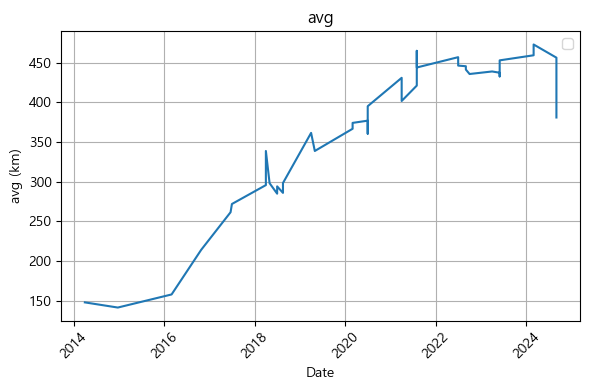

In [4]:
import matplotlib.pyplot as plt

plt.plot(df_avg['Date'], df_avg['MovingAvg_km'])
plt.xlabel('Date')
plt.ylabel('avg (km)')
plt.title('avg')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\junjo\AppData\Local\Temp\ipykernel_49792\1627850053.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


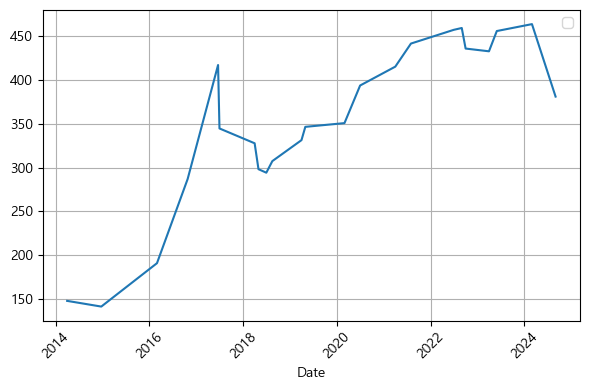

In [5]:
from datetime import timedelta

df_sorted = data_ready.sort_values('Date').reset_index(drop=True)

window_days = 365
moving_averages = []

for i in range(len(df_sorted)):
    current_date = df_sorted.loc[i, 'Date']
    window_start = current_date - timedelta(days=window_days)
    
    window_data = df_sorted[(df_sorted['Date'] > window_start) & (df_sorted['Date'] <= current_date)]
    
    avg = window_data['Range_km'].mean()
    moving_averages.append(avg)

df_sorted['TimeWindowAvg'] = moving_averages
plt.plot(df_sorted['Date'], df_sorted['TimeWindowAvg'],)

plt.xlabel('Date')
plt.ylabel('')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import MonthEnd

kv_list = [
    {row['Date'].strftime('%Y-%m-%d'): row['Range_km']}
    for _, row in data_ready.iterrows()
]

all_values = [list(d.values())[0] for d in kv_list]
q1, q2, q3 = np.percentile(all_values, [25, 50, 75])

overall_list = kv_list.copy()
q1_list = [d for d in kv_list if list(d.values())[0] >= q3]      # 1분위: 상위 25%
q2_list = [d for d in kv_list if q2 <= list(d.values())[0] < q3] # 2분위: 50~75%
q3_list = [d for d in kv_list if q1 <= list(d.values())[0] < q2] # 3분위: 25~50%
q4_list = [d for d in kv_list if list(d.values())[0] < q1]       # 4분위: 하위 25%

# --- 누적 평균을 계산하는 함수 ---
def get_cumulative_means(up_to_ym: str) -> dict:
    end_date = datetime.strptime(up_to_ym + '-01', '%Y-%m-%d') + MonthEnd(0)
    def _mean_upto(lst):
        vals = [
            list(d.values())[0]
            for d in lst
            if datetime.strptime(next(iter(d.keys())), '%Y-%m-%d') <= end_date
        ]
        return np.mean(vals) if vals else np.nan

    return {
        'overall_mean': _mean_upto(overall_list),
        'q1_mean':      _mean_upto(q1_list),
        'q2_mean':      _mean_upto(q2_list),
        'q3_mean':      _mean_upto(q3_list),
        'q4_mean':      _mean_upto(q4_list),
    }

# ---  월 단위로 반복 적용 ---
rows = []
for dt in pd.date_range(start='2015-01-01', end='2025-01-01', freq='MS'):
    ym = dt.strftime('%Y-%m')
    means = get_cumulative_means(ym)
    means['month'] = ym
    rows.append(means)

result_df = pd.DataFrame(rows).set_index('month')

# 누적 평균을 계산한 결과를 채우기
result_df['q3_mean'].fillna(result_df['q4_mean'])
result_df['q2_mean'].fillna(result_df['q3_mean'])
result_df['q1_mean'].fillna(result_df['q2_mean'])

# 결과 확인
print(result_df)


         overall_mean     q1_mean  q2_mean  q3_mean  q4_mean
month                                                       
2015-01    141.500000         NaN      NaN      NaN    141.5
2015-02    141.500000         NaN      NaN      NaN    141.5
2015-03    141.500000         NaN      NaN      NaN    141.5
2015-04    141.500000         NaN      NaN      NaN    141.5
2015-05    141.500000         NaN      NaN      NaN    141.5
...               ...         ...      ...      ...      ...
2024-09    376.707317  504.181818    426.6    354.5    208.8
2024-10    376.707317  504.181818    426.6    354.5    208.8
2024-11    376.707317  504.181818    426.6    354.5    208.8
2024-12    376.707317  504.181818    426.6    354.5    208.8
2025-01    376.707317  504.181818    426.6    354.5    208.8

[121 rows x 5 columns]


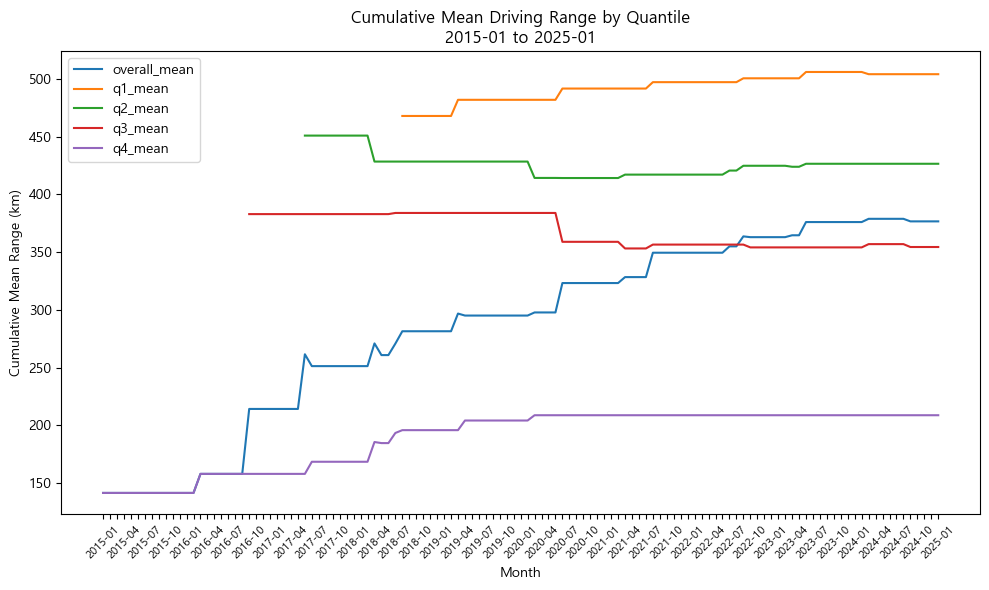

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in result_df.columns:
    ax.plot(result_df.index, result_df[col], label=col)
ax.set_xlabel('Month')
ax.set_ylabel('Cumulative Mean Range (km)')
ax.set_title('Cumulative Mean Driving Range by Quantile\n2015-01 to 2025-01')
ax.legend()
plt.xticks(rotation=45, fontsize=8)

for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % 3 == 0)

plt.tight_layout()
plt.show()

In [8]:
cummax_df = result_df.cummax()

# 결과 확인
print(cummax_df)

         overall_mean  q1_mean  q2_mean  q3_mean  q4_mean
month                                                    
2015-01    141.500000      NaN      NaN      NaN    141.5
2015-02    141.500000      NaN      NaN      NaN    141.5
2015-03    141.500000      NaN      NaN      NaN    141.5
2015-04    141.500000      NaN      NaN      NaN    141.5
2015-05    141.500000      NaN      NaN      NaN    141.5
...               ...      ...      ...      ...      ...
2024-09    378.921053    506.1    451.0    384.0    208.8
2024-10    378.921053    506.1    451.0    384.0    208.8
2024-11    378.921053    506.1    451.0    384.0    208.8
2024-12    378.921053    506.1    451.0    384.0    208.8
2025-01    378.921053    506.1    451.0    384.0    208.8

[121 rows x 5 columns]


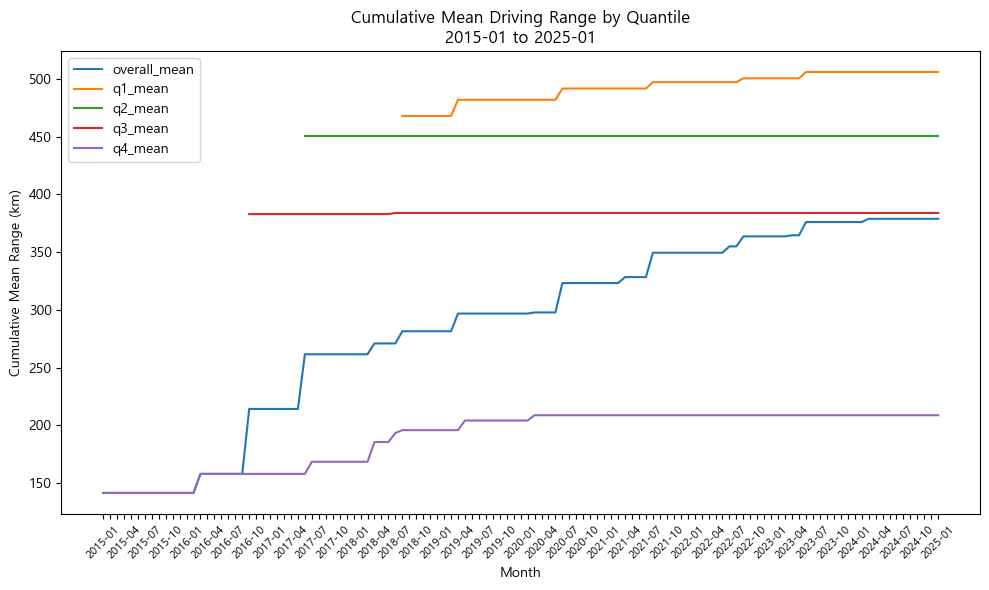

In [9]:
# 7) 그래프 그리기 (x축 라벨을 3번에 하나씩만 표시)
fig, ax = plt.subplots(figsize=(10, 6))

for col in cummax_df.columns:
    ax.plot(cummax_df.index, cummax_df[col], label=col)

ax.set_xlabel('Month')
ax.set_ylabel('Cumulative Mean Range (km)')
ax.set_title('Cumulative Mean Driving Range by Quantile\n2015-01 to 2025-01')
ax.legend()
plt.xticks(rotation=45, fontsize=8)
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % 3 == 0)

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import MonthEnd

kv_list = [
    {row['Date'].strftime('%Y-%m-%d'): row['Range_km']}
    for _, row in data_ready.iterrows()
]


def get_recent20_means(up_to_ym: str) -> dict:
    end_date = datetime.strptime(up_to_ym + '-01', '%Y-%m-%d') + MonthEnd(0)
    window = [
        d for d in kv_list
        if datetime.strptime(next(iter(d.keys())), '%Y-%m-%d') <= end_date
    ]
    window.sort(key=lambda d: datetime.strptime(next(iter(d.keys())), '%Y-%m-%d'))
    recent = window[-20:]
    values = [list(d.values())[0] for d in recent]
    if not values:
        return dict(overall_mean=np.nan, q1_mean=np.nan,
                    q2_mean=np.nan, q3_mean=np.nan, q4_mean=np.nan)
    q25, q50, q75 = np.percentile(values, [25, 50, 75])
    overall = np.mean(values)
    q1 = np.mean([v for v in values if v >= q75]) if any(v >= q75 for v in values) else np.nan
    q2 = np.mean([v for v in values if q50 <= v < q75]) if any(q50 <= v < q75 for v in values) else np.nan
    q3 = np.mean([v for v in values if q25 <= v < q50]) if any(q25 <= v < q50 for v in values) else np.nan
    q4 = np.mean([v for v in values if v < q25]) if any(v < q25 for v in values) else np.nan

    return {
        'overall_mean': overall,
        'q1_mean':      q1,
        'q2_mean':      q2,
        'q3_mean':      q3,
        'q4_mean':      q4,
    }

rows = []
for dt in pd.date_range(start='2013-01-01', end='2025-01-01', freq='MS'):
    ym = dt.strftime('%Y-%m')
    rec = get_recent20_means(ym)
    rec['month'] = ym
    rows.append(rec)

result_df = pd.DataFrame(rows).set_index('month').cummax()

# # --- 3) 결측값을 아래 분위수 값으로 채우기 ---
# # q3_mean 결측 → q4_mean
# result_df['q3_mean'].fillna(result_df['q4_mean'], inplace=True)
# # q2_mean 결측 → q3_mean
# result_df['q2_mean'].fillna(result_df['q3_mean'], inplace=True)
# # q1_mean 결측 → q2_mean
# result_df['q1_mean'].fillna(result_df['q2_mean'], inplace=True)


# --- 3) 결측값을 앞의 값으로 채우기 (forward fill) ---
result_df[['q1_mean', 'q2_mean', 'q3_mean']]= result_df[['q1_mean', 'q2_mean', 'q3_mean']].fillna(method='ffill')

print(result_df)


         overall_mean  q1_mean  q2_mean  q3_mean  q4_mean
month                                                    
2013-01           NaN      NaN      NaN      NaN      NaN
2013-02           NaN      NaN      NaN      NaN      NaN
2013-03           NaN      NaN      NaN      NaN      NaN
2013-04           NaN      NaN      NaN      NaN      NaN
2013-05           NaN      NaN      NaN      NaN      NaN
...               ...      ...      ...      ...      ...
2024-09        451.35    527.8    480.2    432.8    364.6
2024-10        451.35    527.8    480.2    432.8    364.6
2024-11        451.35    527.8    480.2    432.8    364.6
2024-12        451.35    527.8    480.2    432.8    364.6
2025-01        451.35    527.8    480.2    432.8    364.6

[145 rows x 5 columns]


C:\Users\junjo\AppData\Local\Temp\ipykernel_49792\659366686.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result_df[['q1_mean', 'q2_mean', 'q3_mean']]= result_df[['q1_mean', 'q2_mean', 'q3_mean']].fillna(method='ffill')


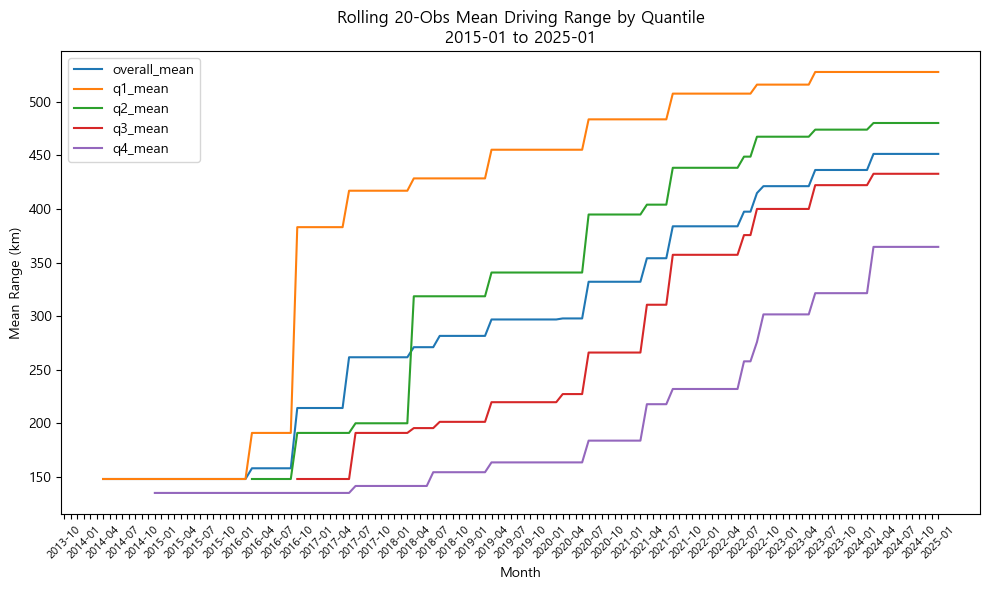

In [11]:
import matplotlib.pyplot as plt

# 그래프 그리기 (마커 없이 선만)
fig, ax = plt.subplots(figsize=(10, 6))

for col in result_df.columns:
    ax.plot(result_df.index, result_df[col], label=col)  # marker 인자 제거

ax.set_xlabel('Month')
ax.set_ylabel('Mean Range (km)')
ax.set_title('Rolling 20-Obs Mean Driving Range by Quantile\n2015-01 to 2025-01')
ax.legend()

# x축 레이블 45도 회전 + 폰트 크기 축소
plt.xticks(rotation=45, fontsize=8)
# 라벨이 너무 겹치면, 3개마다 하나씩만 표시
for i, lbl in enumerate(ax.get_xticklabels()):
    lbl.set_visible(i % 3 == 0)

plt.tight_layout()
plt.show()


In [12]:
result_df.to_csv('../data/processed/final_ev_range.csv', encoding='cp949', index=True)
print("파일 생성 완료")

파일 생성 완료
